<a href="https://colab.research.google.com/github/laurenbchu/LEGALST-123/blob/main/%5BTeam_4%5D_EDA_Resubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UC Berkeley WarnMe Accuracy Analysis: Data Life Cycle**

Through this notebook, our team explores the extent to which UC Berkeley WarnMe alerts reflect the actual criminal activity around the Berkeley campus, via several possible metrics, aiming to uncover the reliability and validity of WarnMe alerts, in terms of representing actual Berkeley crime according to the UCPD.

**Dependencies:**

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from geopy.geocoders import Nominatim
from multiprocessing import Pool
import folium
from folium.plugins import HeatMap
import string
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
!pip install gensim
from gensim import corpora, models
!pip install pyldavis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.9 MB/s eta 0:00:00


----
## **The Data**

We rely on two main datasets: the UCPD Daily Crime Logs and the UC Berkeley WarnMe alerts.

**Crime Logs**: After reaching out to the UCPD, we gained access to PDFs of crime logs from January 2019 to January 2024, which include details about the date/time, case number, category, incident description, location, synopsis, and disposition for each logged crime.

**WarnMes**: We also reached out to the university and received the WarnMe records from August 2nd, 2021 to October 19th, 2023 in PDF format with the categories Message Body, Message Title, and Sent On.

Both of our datasets were given in PDF format, so we had to first convert the data to a csv file, which is imported here. For ease of categorization, we split the crime log entries by year: 2021, 2022, and 2023.

**Importing the Data:**

In [2]:
# Importing the ability to pull files directly from Google Drive
drive.mount('/content/drive')

# Defining the path to pull my specific file
# For Lili only - os.chdir('/content/drive/My Drive/LEGALST 123 Project')
os.chdir('/content/drive/My Drive/LEGALST 123/LEGALST 123 Project')

# Load the XLSX file into a DataFrame
# These are all of the WarnMes from August 2nd, 2021 to October 19th, 2023
warnme = pd.read_excel('WarnMe Records.xlsx')

# Load in the excel sheets for the 2021, 2022, and 2023 UCPD Daily Crime Log data
twentyone = pd.read_excel('Crime Log 2021.xlsx')
twentytwo = pd.read_excel('Crime Log 2022.xlsx')
twentythree = pd.read_excel('Crime Log 2023.xlsx')

Mounted at /content/drive


----

## Section 1: Exploratory Data Analysis

Some of the crime log entries from certain years include typos. For example, the 2021 crime logs have a column named "Locations" instead of "Location" like the other crime logs, and the 2022 crime logs have a column named "Occurred Range" with a space at the end that messes up our merging. As such, we clean up the columns names below.

In [3]:
# Change the column names so that each year's reports match
twentyone.rename(columns={'Locations': 'Location'}, inplace=True)
twentytwo.rename(columns={'Occurred Range ': 'Occurred Range'}, inplace=True)

In order to aid in preliminary data exploration and later visualization, we utilize keyword patterns and regular expressions to categorize each warnme incident as a certain type of incident. The options are: Robbery, Burglary, Assault, Violent Crime, Fire, Police Activity, Hazardous Condition, Theft, All Clear, Scam, Protest, Avoid the Area, Community Advisory, Community Message, Shelter in Place, and Other.

In [4]:
# Create a new column to store the identified incident type
warnme['Incident Type'] = ''

# Define keyword patterns and regular expressions for each type of incident
incident_patterns = {
    'Robbery': r'\b(robbery)\b',
    'Burglary': r'\b(burglary)\b|\b(burglaries)\b',
    'Assault': r'\b(assault)\b|\b(aggravated assault)\b|\b(sexual assault)\b',
    'Violent Crime': r'\b(violent crime)\b',
    'Fire': r'\b(fire)\b',
    'Police Activity': r'\b(police activity)\b',
    'Hazardous Condition': r'\b(hazardous condition)\b|\b(gas)\b',
    'Theft': r'\b(theft)\b',
    'All Clear': r'\b(all clear)\b|\b(area clear)\b',
    'Scam': r'\b(scam)\b',
    'Protest': r'\b(protest)\b',
    'Avoid the Area': r'\b(avoid the area)\b'
}

# Iterate through each row and identify the type of incident
for index, row in warnme.iterrows():
    message = row['Message Body'].lower()
    for incident_type, pattern in incident_patterns.items():
        if re.search(pattern, message):
            warnme.at[index, 'Incident Type'] = incident_type
            break  # Once a match is found, no need to check further

# Filter rows where the 'Incident Type' column is empty
empty = warnme[warnme['Incident Type'] == '']

# Define keyword patterns and regular expressions for each type of incident
keywords = {
    'Violent Crime': r'\b(violent crime)\b',
    'Community Advisory': r'\b(community advisory)\b',
    'Community Message': r'\b(community message)\b',
    'Shelter in Place': r'\b(shelter in place)\b'
}

# Iterate through each row with empty incident type and identify the type of incident using message title
for index, row in empty.iterrows():
    if pd.notnull(row['Message Title']):  # Check if message title exists
        message_title = row['Message Title'].lower()
        for incident_type, pattern in keywords.items():  # Iterate over keywords
            if re.search(pattern, message_title):
                warnme.at[index, 'Incident Type'] = incident_type
                break  # Once a match is found, no need to check further

# Classify the remaining alerts as general Community Advisory or Community Message
final_patterns = {
    'Community Advisory': r'\b(community advisory)\b',
    'Community Message': r'\b(community message)\b',
}

still_empty = warnme[warnme['Incident Type'] == '']
# Iterate through each row and identify the type of incident
for index, row in still_empty.iterrows():
    message = row['Message Body'].lower()
    for incident_type, pattern in final_patterns.items():
        if re.search(pattern, message):
            warnme.at[index, 'Incident Type'] = incident_type
            break  # Once a match is found, no need to check further

# Assign everything else to Other
warnme.loc[warnme['Incident Type'] == '', 'Incident Type'] = 'Other'

Now having classified each WarnMe event with an incident type, we count the frequencies of each incident type below and produce a summary table.

In [5]:
# Count the frequency of each incident type
incident_counts = warnme['Incident Type'].value_counts()

# Create a summary table
warnme_summary = pd.DataFrame({
    'Incident Type Counts': incident_counts
})

warnme_summary['Proportion of All Messages'] = warnme_summary['Incident Type Counts'] / len(warnme)
warnme_summary

,Incident Type Counts,Proportion of All Messages
Incident Type,,
Robbery,49,0.160656
Burglary,43,0.140984
Assault,42,0.137705
Fire,25,0.081967
Violent Crime,25,0.081967
Community Advisory,23,0.075410
Police Activity,18,0.059016
Avoid the Area,18,0.059016
Other,13,0.042623


Next, we combine the 2021, 2022, and 2023 crime logs into one large dataframe of all of the crime log entires, in a DataFrame called "crimelog". Then, just as we did above with the WarnMes, we categorize each crime log entry as an incident type. The incident types are: Robbery, Burglary, Assault, Battery, Violent Crime, Fire, Police Activity, Hazardous Condition, Theft, All Clear, Scam, Protest, Avoid the Area, Weapons, and Other.

In [6]:
# concatenate 2021, 2022, and 2023 crime logs
crimelog = pd.concat([twentyone, twentytwo, twentythree], ignore_index=True)

# Clean and condense crime categories
# Create a new column to store the identified incident type
crimelog['Incident Type'] = ''

# Define keyword patterns and regular expressions for each type of incident in Crime Log that corresponds with WarnMe
incident_patterns = {
    'Robbery': r'\b(robbery)\b',
    'Burglary': r'\b(burglary)\b|\b(burglaries)\b',
    'Assault': r'\b(assault)\b|\b(aggravated assault)\b|\b(sexual assault)\b|\b(rape)\b',
    'Battery': r'\b(battery)\b',
    'Violent Crime': r'\b(violent crime)\b',
    'Fire': r'\b(fire)\b',
    'Police Activity': r'\b(police activity)\b',
    'Hazardous Condition': r'\b(hazardous condition)\b|\b(gas)\b',
    'Theft': r'\b(theft)\b',
    'All Clear': r'\b(all clear)\b|\b(area clear)\b',
    'Scam': r'\b(scam)\b',
    'Protest': r'\b(protest)\b',
    'Avoid the Area': r'\b(avoid the area)\b',
    'Weapons':r'\b(weapon)\b',
}

crimelog['Crime(s)'] = crimelog['Crime(s)'].astype(str)

# Iterate through each row and identify the type of incident
for index, row in crimelog.iterrows():
    message = row['Crime(s)'].lower()
    for incident_type, pattern in incident_patterns.items():
        if re.search(pattern, message):
            crimelog.at[index, 'Incident Type'] = incident_type
            break  # Once a match is found, no need to check further

# Filter rows where the 'Incident Type' column is empty
empty = crimelog[crimelog['Incident Type'] == '']


still_empty = crimelog[crimelog['Incident Type'] == '']
# Iterate through each row and identify the type of incident
for index, row in still_empty.iterrows():
    message = row['Crime(s)'].lower()
    for incident_type, pattern in final_patterns.items():
        if re.search(pattern, message):
            crimelog.at[index, 'Incident Type'] = incident_type
            break  # Once a match is found, no need to check further

# Assign everything else to Other
crimelog.loc[crimelog['Incident Type'] == '', 'Incident Type'] = 'Other'

Now having classified each crime log entry with an incident type, we count the frequencies of each incident type below and produce a summary table.

In [7]:
# Create a summary table for the frequency of each incident type in crime log
crimelog_summary = pd.DataFrame({
    'Incident Type Counts': crimelog['Incident Type'].value_counts()
})

crimelog_summary['Proportion of All UCPD Messages'] = crimelog_summary['Incident Type Counts'] / len(crimelog)

crimelog_summary

,Incident Type Counts,Proportion of All UCPD Messages
Incident Type,,
Other,5464,0.620909
Theft,1981,0.225114
Burglary,455,0.051705
Battery,297,0.033750
Fire,268,0.030455
Assault,172,0.019545
Robbery,93,0.010568
Weapons,39,0.004432
Hazardous Condition,31,0.003523


Having classified all of the WarnMe and Crime Log data, we now want to compare the two distributions. To do so, we must complete some preprocessing, as seen below. We first convert all of the date/time variables in both datasets to datetime objects, and then pull just the dates from each dataset and make it their own columns. From there, we drop some columns for simplicity's sake, then join the two datasets together. Then with this merged dataset, we create a contingency matrix, and relabel it for clarity's sake.  The number in the right-hand column is the number of WarnMe incidents in each category that have corresponding observations - matched just by date - in the UCPD dataset.

In [8]:
# Converting all time variables to datetime objects for ease of use
warnme['Sent On'] = pd.to_datetime(warnme['Sent On'].str[:-4], errors='coerce')
crimelog['Occurred Range'] = pd.to_datetime(crimelog['Occurred Range'], errors='coerce')
crimelog['Reported'] = pd.to_datetime(crimelog['Reported'], errors='coerce')
warnme['Date'] = warnme['Sent On'].dt.date
crimelog['Date'] = crimelog['Occurred Range'].dt.date

# Setting the Index of new WarnMe table to the date and dropping unnecessary data
warnme_cm = warnme.copy().drop(labels = ['Message Body', 'Message Title', 'Sent On'], axis = 1).set_index('Date')

# Setting index of new Crime Log table to the date
crimelog_cm = crimelog.copy().drop(
    labels = ['Index', 'Case', 'Crime(s)', 'Reported', 'Occurred Range', 'Location'], axis = 1).set_index('Date')

# Sticking together both datasets
stuck_together = warnme_cm.join(crimelog_cm, on='Date',  how='left', lsuffix='_warnme_cm', rsuffix='_crimelog_cm')

In [9]:
# Create a contingency matrix for comparison
contingency_matrix = stuck_together.groupby(["Incident Type_warnme_cm"]).count().reset_index()
contingency_matrix = contingency_matrix.rename(columns={"Incident Type_warnme_cm":"WarnMe Incident Classification",
                                   "Incident Type_crimelog_cm":"# of Corresponding UCPD Incidents"})
contingency_matrix = contingency_matrix.drop(columns=['Unnamed: 3', 'Unnamed: 7', 'Unnamed: 8'])
contingency_matrix.sort_values('# of Corresponding UCPD Incidents', ascending=False)

,WarnMe Incident Classification,# of Corresponding UCPD Incidents
11,Robbery,497
3,Burglary,440
1,Assault,408
4,Community Advisory,268
6,Fire,237
9,Police Activity,234
15,Violent Crime,228
2,Avoid the Area,139
8,Other,134
13,Shelter in Place,120


# **General Findings from the Exploratory Data Analysis**
Looking at the WarnMe summary table, we can see that the top 5 most frequently reported types of incidents are Robbery (16%), Burglary (14%), Assault (14%), Fire (8%), and Violent Crime (8%), making up around 60% of all WarnMe alerts. This makes sense, given that WarnMe are sent out for the students, staff, and faculty of the university to be aware of, and these incident types are all dangers that they should be made aware of.

Looking at the Crime Logs summary table, we can see that the top 5 most frequently reported types of incidents are Other (62%), Theft (22%), Burlgary (5%), Battery (3%), and Fire (3%). The high proportion of incidents classified as Other indicates that the Crime Logs are much more all-encompassing as compared to the WarnMes, in terms of the types of crimes that they report on. However, the remaining 4 top incident categories match closely with the WarnMes, suggesting a preliminary assessment that the WarnMe alerts are an accurate distribution of the Crime Log entries.

Looking at the contigency table, the number of WarnMe incidents in each category that have corresponding observations - matched just by date - in the UCPD dataset, match roughly the same distributions as described above, corroborating our findings.

In order to develop more findings, we've provided a variety of data visualizations below based upon the data for ease of understanding.

The following graph represents the changes in crime activity from 2021 to 2023, according to the UCPD Daily Crime Logs. Most notably, there is an increase overtime in the number of reported incidents, suggesting possibly that the state of crime in Berkeley is getting worse.

Text(0, 0.5, 'Number of Reported Incidents')

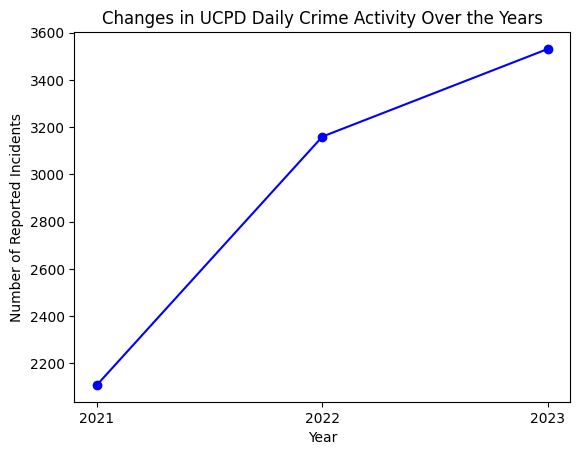

In [10]:
# Counts of entries in the Crime Logs for each year
crime_counts = [twentyone.shape[0], twentytwo.shape[0], twentythree.shape[0]]
plt.plot([2021, 2022, 2023], crime_counts, marker='o', linestyle='-', color='b')
plt.xticks([2021, 2022, 2023])
plt.title('Changes in UCPD Daily Crime Activity Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Reported Incidents')

The following graph represents the top 10 locations mentioned in the UCPD Daily Crime Logs, between 2021 and 2023, showing most notably that all of locations are either on or in close proximity to campus.

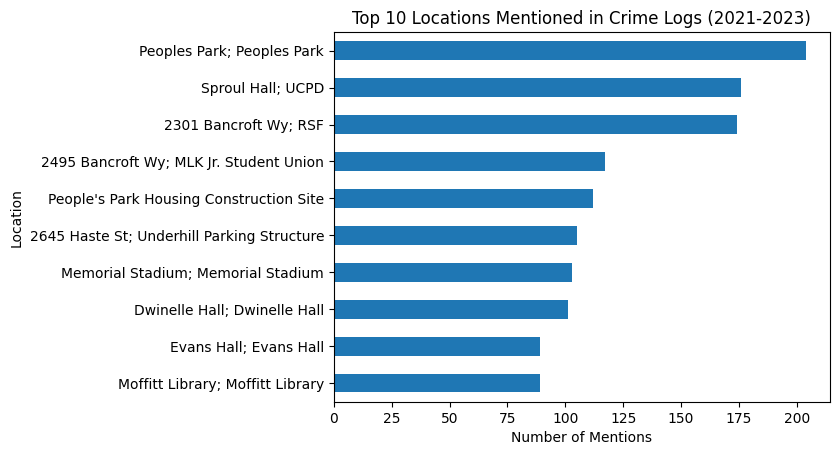

In [11]:
# Aggregating location data from the crime logs of all years and identifying the most mentioned locations
location_counts = crimelog['Location'].value_counts().head(10)

location_counts.plot(kind='barh')
plt.title('Top 10 Locations Mentioned in Crime Logs (2021-2023)')
plt.xlabel('Number of Mentions')
plt.ylabel('Location')
plt.gca().invert_yaxis()

The final graph below compares the proportion of incident types in the WarnMe Reports and the UCPD Crime Logs. From this graph, we can see that WarnMes report a higher proportion of most incident types, but this is largely due to the fact that the "Other" category dominates so heavily, as we discussed prior.

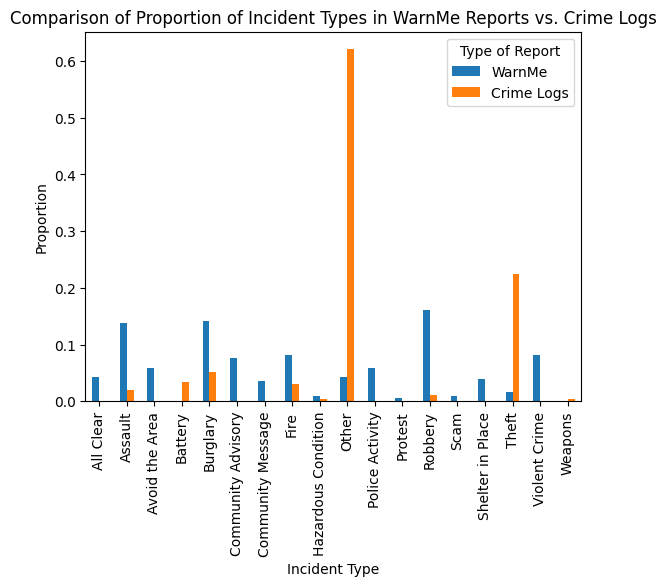

In [12]:
# Comparison of Proportion of Incident Types in WarnMe Reports vs. Crime Logs

warnme_proportion = warnme_summary['Proportion of All Messages']
crimelog_proportion = crimelog_summary['Proportion of All UCPD Messages']

# Combine into one DataFrame
comparison = pd.DataFrame({
    'WarnMe': warnme_proportion,
    'Crime Logs': crimelog_proportion
}).fillna(0)

comparison.plot(kind='bar')
plt.title('Comparison of Proportion of Incident Types in WarnMe Reports vs. Crime Logs')
plt.ylabel('Proportion')
plt.legend(title='Type of Report')